Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [49]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Defining the path for train and test images
data_dir = '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection'
data_dir_train = pathlib.Path(data_dir + '/' + 'Train')
data_dir_test = pathlib.Path(data_dir + '/' + 'Test')


In [52]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [53]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [54]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.


In [55]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [56]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

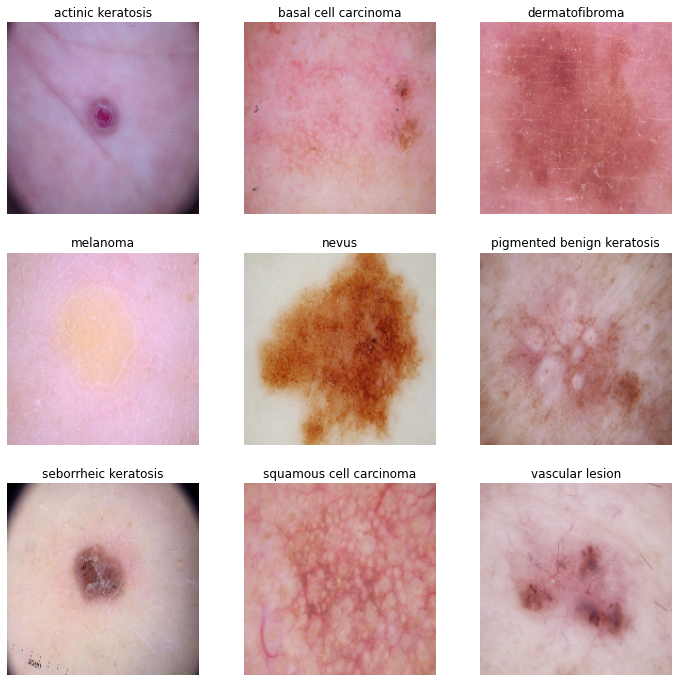

In [57]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,12))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [59]:
### Standardize the data
# let's inlcude layer inside model definition for normalization
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [60]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [62]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 19s 69ms/step - loss: 2.0295 - accuracy: 0.2715 - val_loss: 2.1650 - val_accuracy: 0.2034
Epoch 2/20
70/70 [==============================] - 2s 22ms/step - loss: 1.6507 - accuracy: 0.4408 - val_loss: 2.2058 - val_accuracy: 0.2966
Epoch 3/20
70/70 [==============================] - 2s 22ms/step - loss: 1.4329 - accuracy: 0.5114 - val_loss: 2.2762 - val_accuracy: 0.3220
Epoch 4/20
70/70 [==============================] - 2s 21ms/step - loss: 1.3238 - accuracy: 0.5386 - val_loss: 2.4628 - val_accuracy: 0.3051
Epoch 5/20
70/70 [==============================] - 1s 21ms/step - loss: 1.2250 - accuracy: 0.5735 - val_loss: 2.3575 - val_accuracy: 0.3898
Epoch 6/20
70/70 [==============================] - 2s 24ms/step - loss: 1.1686 - accuracy: 0.5931 - val_loss: 2.8435 - val_accuracy: 0.3390
Epoch 7/20
70/70 [==============================] - 2s 23ms/step - loss: 1.1557 - accuracy: 0.5936 - val_loss: 2.6641 - val_accuracy: 0.3559
Epoch 8/20
7

### Visualizing training results

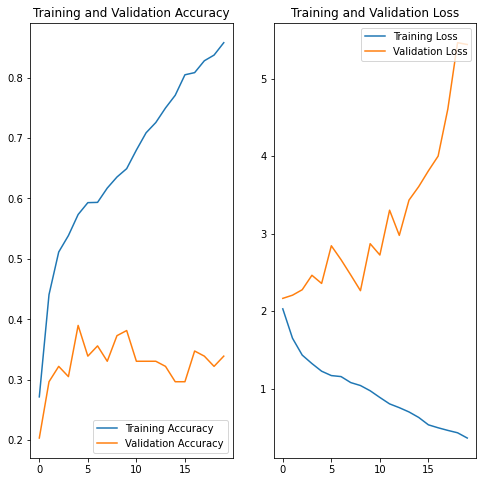

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings
## Observations
* Performance of model is high and low against training & validation data, respectively
* It is sign of overfitting

### Compile model with alternate 'optimizer'

In [64]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train model with 'sgd' optimizer


In [65]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 2s 23ms/step - loss: 195.2082 - accuracy: 0.2068 - val_loss: 2.1908 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 1s 21ms/step - loss: 2.1632 - accuracy: 0.2063 - val_loss: 2.1846 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 1s 21ms/step - loss: 2.1427 - accuracy: 0.2063 - val_loss: 2.1804 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 1s 21ms/step - loss: 2.1252 - accuracy: 0.2063 - val_loss: 2.1777 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 1s 21ms/step - loss: 2.1102 - accuracy: 0.2063 - val_loss: 2.1764 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 1s 21ms/step - loss: 2.0975 - accuracy: 0.2063 - val_loss: 2.1762 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 1s 21ms/step - loss: 2.0865 - accuracy: 0.2063 - val_loss: 2.1767 - val_accuracy: 0.1356
Epoch 8/20


### Visualize Training Results for 'sgd'

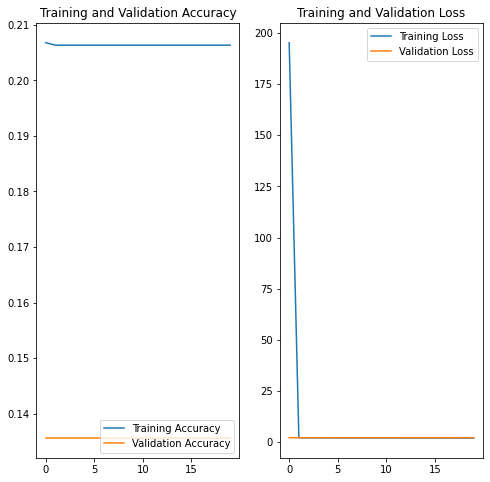

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


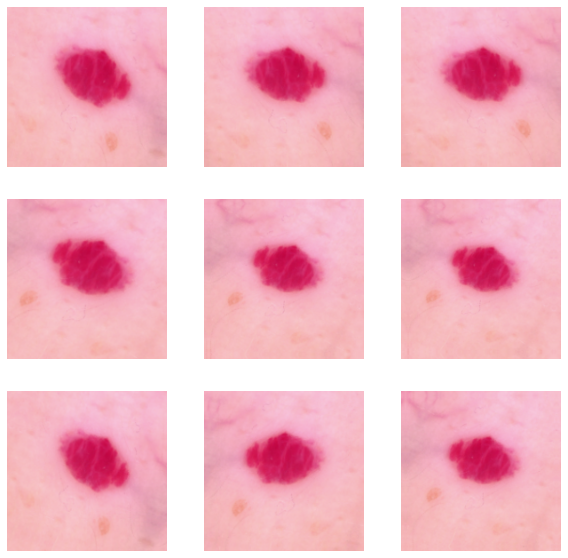

In [68]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [69]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_with_dropout = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [70]:
model_with_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_with_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [71]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_with_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 3s 27ms/step - loss: 1.8856 - accuracy: 0.3144 - val_loss: 2.1265 - val_accuracy: 0.2627
Epoch 2/20
70/70 [==============================] - 2s 24ms/step - loss: 1.5889 - accuracy: 0.4234 - val_loss: 2.1165 - val_accuracy: 0.3644
Epoch 3/20
70/70 [==============================] - 2s 24ms/step - loss: 1.4289 - accuracy: 0.4922 - val_loss: 2.0842 - val_accuracy: 0.3644
Epoch 4/20
70/70 [==============================] - 2s 24ms/step - loss: 1.4344 - accuracy: 0.4980 - val_loss: 2.1792 - val_accuracy: 0.2966
Epoch 5/20
70/70 [==============================] - 2s 24ms/step - loss: 1.3785 - accuracy: 0.5051 - val_loss: 2.0345 - val_accuracy: 0.3305
Epoch 6/20
70/70 [==============================] - 2s 24ms/step - loss: 1.2778 - accuracy: 0.5480 - val_loss: 2.3939 - val_accuracy: 0.3475
Epoch 7/20
70/70 [==============================] - 2s 24ms/step - loss: 1.2601 - accuracy: 0.5511 - val_loss: 2.4461 - val_accuracy: 0.3559
Epoch 8/20
70

### Visualizing the results

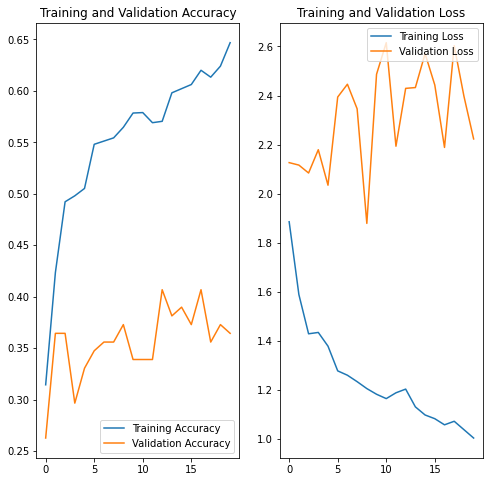

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation:
* There is drop in training and accuracy, with slight imporvement of accuracy for validation data
* 

# Let's Create another model with Dropout, L2 regularization

## Build Model

In [73]:
model_with_dropout_l2_norm = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128,kernel_regularizer=l2(0.01), activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
  #layers.Activation('softmax')
])

## Compile model

In [74]:
model_with_dropout_l2_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_with_dropout_l2_norm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

# Train the model

In [75]:
epochs = 20
history = model_with_dropout_l2_norm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 3s 26ms/step - loss: 2.4589 - accuracy: 0.2108 - val_loss: 2.4069 - val_accuracy: 0.1610
Epoch 2/20
70/70 [==============================] - 2s 25ms/step - loss: 1.8261 - accuracy: 0.3636 - val_loss: 2.1710 - val_accuracy: 0.2797
Epoch 3/20
70/70 [==============================] - 2s 24ms/step - loss: 1.6844 - accuracy: 0.4372 - val_loss: 2.0961 - val_accuracy: 0.2797
Epoch 4/20
70/70 [==============================] - 2s 24ms/step - loss: 1.6083 - accuracy: 0.4752 - val_loss: 2.1499 - val_accuracy: 0.3475
Epoch 5/20
70/70 [==============================] - 2s 24ms/step - loss: 1.5797 - accuracy: 0.4761 - val_loss: 2.2783 - val_accuracy: 0.3220
Epoch 6/20
70/70 [==============================] - 2s 25ms/step - loss: 1.5546 - accuracy: 0.4917 - val_loss: 2.1550 - val_accuracy: 0.3729
Epoch 7/20
70/70 [==============================] - 2s 24ms/step - loss: 1.5017 - accuracy: 0.5074 - val_loss: 2.0533 - val_accuracy: 0.3305
Epoch 8/20
70

## Visualizing the results

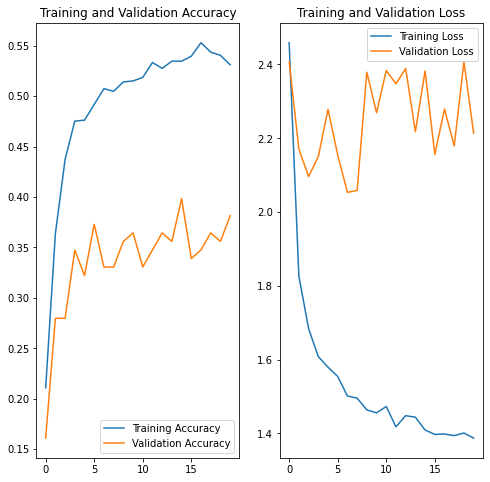

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [77]:
## Your code goes here.
# let's browse training folders for understanding distribution of data

for subdir, dirs, files in os.walk(data_dir_train):
  category_name = os.path.basename(subdir)
  if category_name == os.path.basename(data_dir_train):
    continue
  img_distribution = (len(files)/len(list(data_dir_train.glob('*/*.jpg')))) * 100
  print(str(category_name) + ' has ' + str(len(files)) + ' images ' + 'i.e. about ' + "{:.2f}".format(img_distribution) + '%' + ' of total.')

actinic keratosis has 114 images i.e. about 5.09% of total.
basal cell carcinoma has 376 images i.e. about 16.79% of total.
dermatofibroma has 95 images i.e. about 4.24% of total.
melanoma has 438 images i.e. about 19.56% of total.
nevus has 357 images i.e. about 15.94% of total.
pigmented benign keratosis has 462 images i.e. about 20.63% of total.
seborrheic keratosis has 77 images i.e. about 3.44% of total.
squamous cell carcinoma has 181 images i.e. about 8.08% of total.
vascular lesion has 139 images i.e. about 6.21% of total.


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### * <b>seborrheic keratosis</b> has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### * <b>pigmented benign keratosis</b> class has the highest proportion of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [78]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [79]:
path_to_training_dataset= '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train'

import Augmentor
for i in class_names:
  #print(path_to_training_dataset + '/'+ i)
  p = Augmentor.Pipeline(path_to_training_dataset + '/'+ i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1C746C90>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1D068110>: 100%|██████████| 500/500 [00:21<00:00, 23.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1C746C90>: 100%|██████████| 500/500 [00:21<00:00, 22.74 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FACB08B36D0>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FAC1C811910>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1CD54FD0>: 100%|██████████| 500/500 [00:18<00:00, 27.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FAC1CA3A710>: 100%|██████████| 500/500 [00:42<00:00, 11.87 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1C902B10>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FAC1D0B33D0>: 100%|██████████| 500/500 [00:18<00:00, 27.21 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [80]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [81]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_7a34e7f0-f669-438f-9d0d-7f9b2dba6549.jpg',
 '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_f3a046a2-80c6-40f2-b76c-64aedb5fdee5.jpg',
 '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_49b5daa9-bf82-4359-9d1f-daf4a43faf78.jpg',
 '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_1f583573-f94a-4693-975e-0e1a197cce12.jpg',
 '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_53d52204-6391-4d53-ab82-54f743407f5b.jpg',
 '/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train/actinic keratosis/output/actinic keratosis_original_ISIC

In [82]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [83]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [84]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#df2
#new_df = original_df.append(df2)

In [85]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [86]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [87]:
data_dir_train="/content/drive/MyDrive/00-Dataset/01-Melanoma-Detection/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [88]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [89]:
## your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [90]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [91]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 42s 239ms/step - loss: 1.7817 - accuracy: 0.3203 - val_loss: 1.4946 - val_accuracy: 0.4603
Epoch 2/50
169/169 [==============================] - 30s 173ms/step - loss: 1.3988 - accuracy: 0.4724 - val_loss: 1.2557 - val_accuracy: 0.5620
Epoch 3/50
169/169 [==============================] - 30s 173ms/step - loss: 1.1473 - accuracy: 0.5796 - val_loss: 1.1712 - val_accuracy: 0.5650
Epoch 4/50
169/169 [==============================] - 32s 183ms/step - loss: 0.9096 - accuracy: 0.6762 - val_loss: 1.0467 - val_accuracy: 0.6355
Epoch 5/50
169/169 [==============================] - 30s 172ms/step - loss: 0.7202 - accuracy: 0.7446 - val_loss: 0.9458 - val_accuracy: 0.6689
Epoch 6/50
169/169 [==============================] - 30s 171ms/step - loss: 0.5670 - accuracy: 0.7975 - val_loss: 0.8817 - val_accuracy: 0.7164
Epoch 7/50
169/169 [==============================] - 30s 172ms/step - loss: 0.4649 - accuracy: 0.8372 - val_loss: 0.8777 - val_ac

#### **Todo:**  Visualize the model results

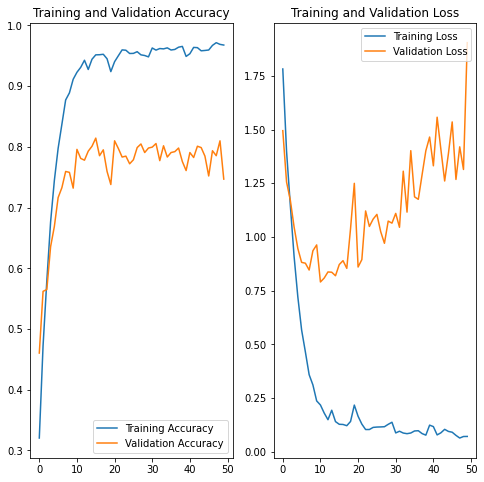

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Findings/Observations
* Data Augmentation for balancing class distribution has helped in better performance of model during validation
* Model performance for training and validation though has difference, but gap has reduced significantly. Hence, we can belive overfitting has reduced with data augmentatin
